In [1]:
import matplotlib.pyplot as plt
import numpy as np
import io,os
import datetime as dt
from h5py import File
import pandas as pd
import netCDF4 as nc
import scipy
import glob
import pdb
import geopandas as gpd
from turfpy.measurement import boolean_point_in_polygon
from turfpy.transformation import intersect
from geojson import Point, Polygon, Feature
from cartopy import crs as ccrs
from scipy.interpolate import RectBivariateSpline,RegularGridInterpolator

In [2]:
files = glob.glob(f'/work2/07655/tg869546/stampede3/nyc-chem/2023/wrfout/*{'d02'}*')
wrf_f = File(files[0])
wrf_lat,wrf_lon = wrf_f['XLAT'][:][0],wrf_f['XLONG'][:][0]
poly_verts = [(float(wrf_lat[0,0]),float(wrf_lon[0,0])),(float(wrf_lat[-1,0]),float(wrf_lon[-1,0])),(float(wrf_lat[-1,-1]),float(wrf_lon[-1,-1])),(float(wrf_lat[0,-1]),float(wrf_lon[0,-1]))]
bbox = Feature(geometry=Polygon((poly_verts,)))

poly_verts2 = [(40,-75),(42,-75),(42,-72),(40,-72)]
bbox2 = Feature(geometry=Polygon((poly_verts2,)))

bbox3 = intersect([bbox,bbox2])
print(bbox3)

{"geometry": {"coordinates": [[[40.199211, -75.0], [40.0, -73.990233], [40.0, -72.629724], [41.519798, -72.073883], [42.0, -74.506105], [42.0, -74.899748], [41.692016, -75.0], [40.199211, -75.0]]], "type": "Polygon"}, "properties": {}, "type": "Feature"}


## Read in the NYC Emissions

In [3]:
fp_file = File(glob.glob(f'/scratch/07351/tg866507/halo/out_300m/col_footprints/20230726_F1/*foot.nc')[0],'r')
fp_lat = fp_file['lat'][:]
fp_lon = fp_file['lon'][:]

#emis = {}
emis_names = ['pitt','epa','edgar']
#with File('/scratch/07351/tg866507/halo-staaqs/nyc_ch4_emissions.h5','r') as f:
#    for nm in emis_names:
#        emis[nm] = {}
#        e_lat = f['lat'][:]
#        e_lon = f['lon'][:]
#        fch4 = f[nm][:]
        #emis[nm]['fch4'] = np.array([RegularGridInterpolator((e_lat,e_lon),fch4[i],method='nearest')(fp_lat,fp_lon) for i in range(fch4.shape[0])])
#        emis[nm] = fch4[:]
#        emis[nm+'_categories'] = f.attrs[f'{nm}_categories'].split(';')

emis_regrid = {}
with File('/scratch/07351/tg866507/halo-staaqs/nyc_emissions_regrid.h5','r') as f:
    for nm in emis_names:
        emis_regrid[nm] = {}
        fp_lat = f['lat'][:]
        fp_lon = f['lon'][:]
        emis_regrid[nm] = f[nm][:]
        emis_regrid[nm+'_categories'] = f.attrs[f'{nm}_categories'].split(';')


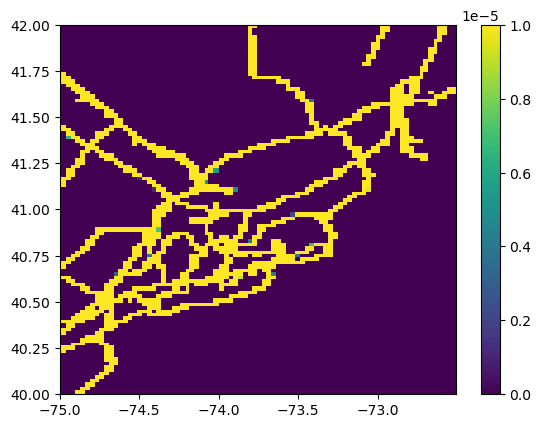

In [4]:
plt.figure()
#fch4_t = RectBivariateSpline(e_lat,e_lon,emisc['pitt']['fch4'][0],kx=1,ky=1)(fp_lat,fp_lon)
plt.pcolormesh(fp_lon,fp_lat,emis_regrid['pitt'][0],vmin=0,vmax=1e-5); plt.colorbar()


## Read in HALO Data and WRF boundary files to create enhancements
### `rec` is a dictionary for each flight with the receptor footprint, GHG boundary condition, and pressure
#### This is if we want the gas values at each level individually

In [5]:
flts = ['20230726_F1']#,'20230726_F2','20230728_F1','20230728_F2','20230805_F1','20230809_F1']
rec = {}
col = {}
obs_nums = {}
levs = {}
for flt in flts:
    fp_prefix = f'bnd/{flt}/'
    rec[flt] = {}
    col[flt] = {}
    bnd_files = []
    rec[flt]['obs_num'] = [int(fi.split('/')[-1]) for fi in sorted(glob.glob(f'/scratch/07351/tg866507/halo-staaqs/bnd/{flt}/*'))][:1000]
    levs[flt] = sorted([int(fi.split('/')[-1].split('_')[3]) for fi in sorted(glob.glob(f'/scratch/07351/tg866507/halo-staaqs/bnd/{flt}/00001/*wrfd02.h5'))])
    for v in ['p','co2','ch4']:
        rec[flt][v] = np.zeros((len(rec[flt]['obs_num']),len(levs[flt])))
    for v in ['co2_bc','ch4_bc']:
        rec[flt][v] = np.zeros((len(rec[flt]['obs_num']),len(levs[flt])))
    for v in ['psfc','lat','lon','time','xch4_bc','xco2_bc']:
        rec[flt][v] = np.zeros(len(rec[flt]['obs_num']))
    for iob,ob in enumerate(rec[flt]['obs_num']):
        ob_files = sorted(glob.glob(f'/scratch/07351/tg866507/halo-staaqs/bnd/{flt}/{ob:05d}/*wrfd02.h5'))
        for iz,z in enumerate(levs[flt]):
            f = File(glob.glob(f'/scratch/07351/tg866507/halo-staaqs/bnd/{flt}/{ob:05d}/*_{z}_*wrfd02.h5')[0])
            rec[flt]['co2_bc'][iob,iz] = np.median(f['boundary']['wrf_bc_co2'][:])
            rec[flt]['ch4_bc'][iob,iz] = np.median(f['boundary']['wrf_bc_ch4'][:])
            rec[flt]['p'][iob,iz] = f['receptor']['pressure'][:][0,0]
            for sfx in ['ANT','BIO']:
                rec[flt]['co2'][iob,iz] += f['receptor'][f'CO2_{sfx}'][:][0,0]
            rec[flt]['co2'][iob,iz] -= f['receptor'][f'CO2_BCK'][:][0,0]
            rec[flt]['ch4'][iob,iz] = f['receptor'][f'CH4_ANT'][:][0,0]
        rec[flt]['psfc'][iob] = f['receptor'][f'psfc'][0,0]
        rec[flt]['lat'][iob] = f['receptor'][f'lat'][0]
        rec[flt]['lon'][iob] = f['receptor'][f'lon'][0]
        rec[flt]['time'][iob] = f['receptor'][f'time'][0]
        
        #Compute the column values
        p_inds = np.argsort(rec[flt]['p'][iob])
        p_ext = [rec[flt]['psfc'][iob]]
        p_ext.extend(rec[flt]['p'][iob,p_inds[::-1]])
        p_sort = np.array(p_ext)
        dp = []
        dp.extend(-np.diff(p_sort))
        dp = np.array(dp)
        
        rec[flt]['xco2_bc'][iob]= np.dot(rec[flt]['co2_bc'][iob],dp)/dp.sum()
        rec[flt]['xch4_bc'][iob]= np.dot(rec[flt]['ch4_bc'][iob],dp)/dp.sum()       

#### This is if we just want the Xgas values for each flight track element

In [6]:
flts = ['20230726_F1','20230726_F2','20230728_F1','20230728_F2','20230805_F1','20230809_F1']
col = {}
for flt in flts:
    col[flt] = {}
    f = File(f'/scratch/07351/tg866507/halo-staaqs/bnd/wrf_d02/{flt}_xbnd.h5','r')
    for v in ['lon','lat','xwrf_bc_co2','xwrf_bc_ch4','obs_id']:
        col[flt][v] = f[v][:]

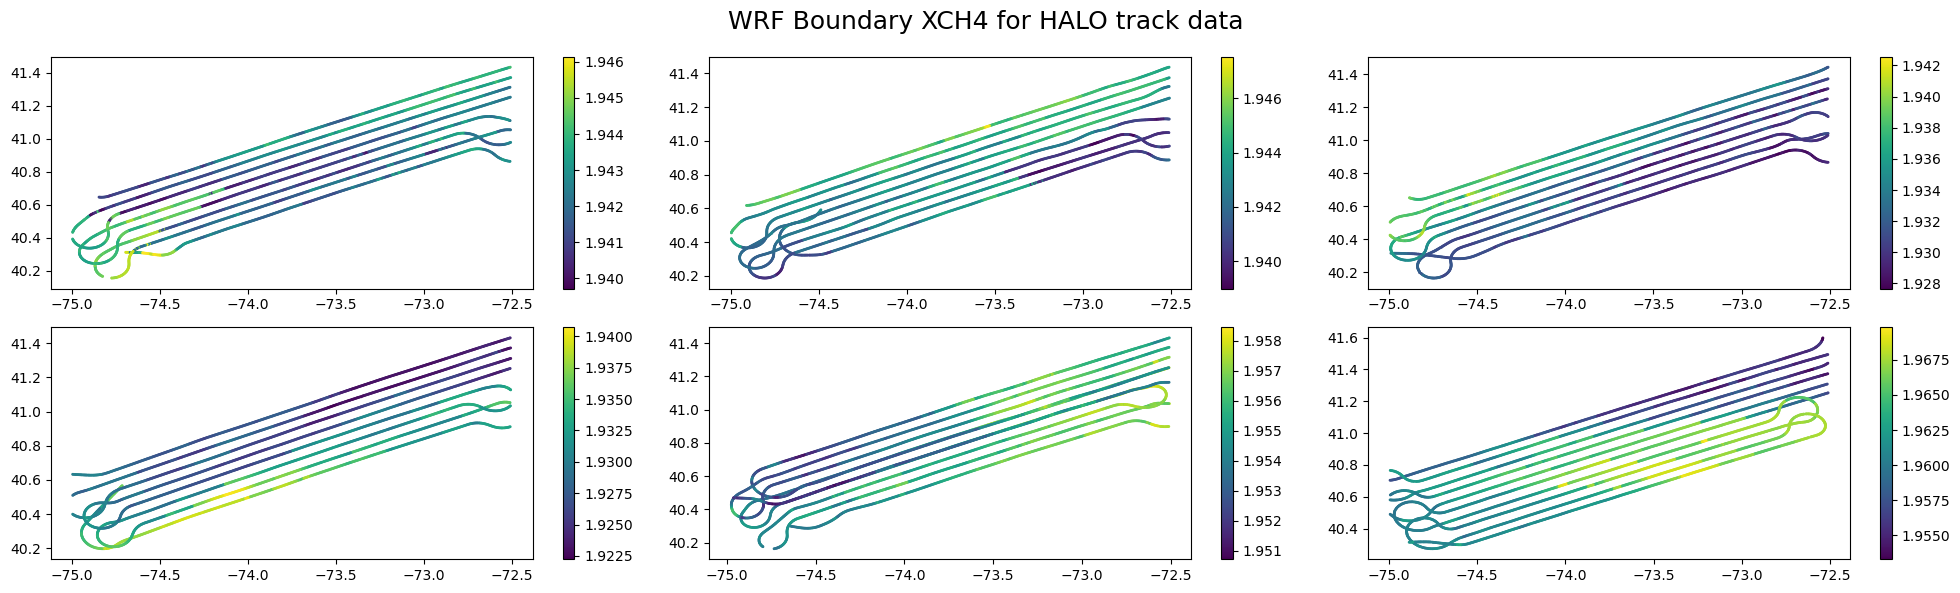

In [7]:
fig,axs = plt.subplots(2,3,figsize=(20,6))
for iflt,flt in enumerate(flts):
    ax = axs[iflt//3,iflt%3]
    g = ax.scatter(col[flt]['lon'],col[flt]['lat'],c=col[flt]['xwrf_bc_ch4']*1.015,s=1)
    plt.colorbar(g,ax=ax)
fig.suptitle('WRF Boundary XCH4 for HALO track data',fontsize=18)    
plt.tight_layout()


In [14]:
fpt ={}
for flt in flts[:1]:
    fpt_files = np.array(glob.glob(f'/scratch/07351/tg866507/halo/out_300m/col_footprints/{flt}/*foot.nc'))
    fpt_id = np.array([int(fi.split('/')[-1].split('_')[-2]) for fi in fpt_files])
    for enm in emis_names:
        col[flt][f'dxch4_{enm}'] = np.zeros((len(col[flt]['obs_id']),emis_regrid[enm].shape[0])) # saving out the enhancements
    fpt[flt] = {'foot':np.zeros((len(col[flt]['obs_id']),len(fp_lat),len(fp_lon))),'obs_id':np.array([None for i in range(len(col[flt]['obs_id']))])}
    for iob,ob in enumerate(col[flt]['obs_id']): # fi ~ 202307261606_-74.8424_40.6449_750_traj_bnd_wrfd01.h5
        ind = np.where(fpt_id == ob)[0][0]
        ft = File(fpt_files[ind],'r')['pwcol_fp'][:].sum(0)
        for enm in emis_names:
            col[flt][f'dxch4_{enm}'][iob] = (emis_regrid[enm]*ft[:]).sum((1,2)) 
        fpt[flt]['foot'][iob] = ft[:]
        fpt[flt]['obs_id'][iob] = ob

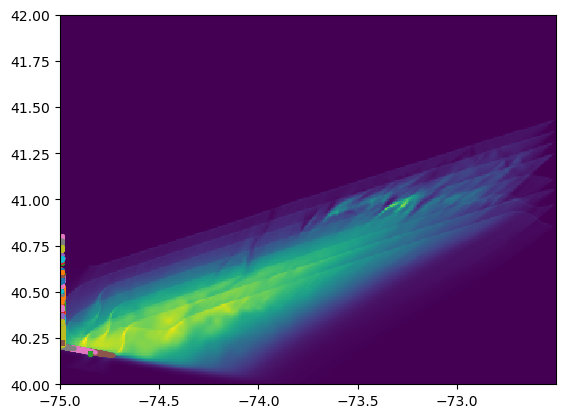

In [21]:
plt.pcolormesh(fp_lon,fp_lat,fpt[flt]['foot'].sum(0))
#plt.figure()
for i in fpt[flt]['obs_id'][::100]:
    fi = glob.glob(f'/scratch/07351/tg866507/halo-staaqs/bnd/wrf_d02/{flt}/{i:05d}/*_10000_*')[0]
    f = File(fi)
    lat = f['boundary/part_lat'][:]
    lon = f['boundary/part_lon'][:]
    plt.scatter(lon,lat,s=5,zorder=1)
#plt.pcolormesh(flt_fpt[1000])

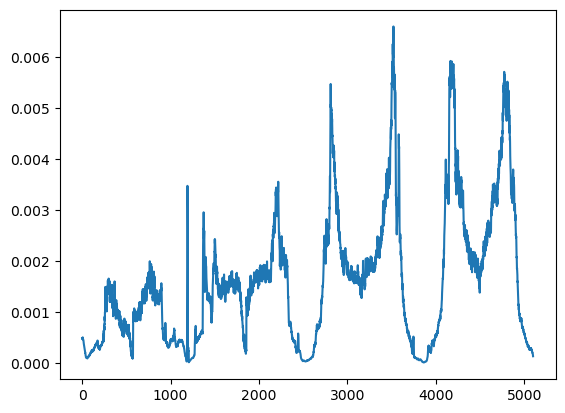

In [22]:
plt.plot(col['20230726_F1']['dxch4_pitt'].sum(1))

### `halo` is a dictionary with the HALO data and enhancements from the model background

In [45]:
halo = {}
for flt in flts:
    f = File(f'/scratch/07351/tg866507/halo-staaqs/flight_data/{flt}_subCH4_300m.h5','r')
    halo[flt] = {}
    all_oid = np.arange(1,len(f['lat'][:])+1)
    inds = []
    for oid in col[flt]['obs_id']:
        oind = np.where(all_oid == oid)[0]
        if len(oind) == 0: continue
        inds.append(oind[0])
    
    halo[flt]['lat'] = f['lat'][:][inds]
    halo[flt]['lon'] = f['lon'][:][inds]
    halo[flt]['xch4'] = f['xch4'][:][inds]
    halo[flt]['time'] = f['time'][:][inds]
    halo[flt]['obs_id'] = all_oid[inds]

[  16   17   18 ... 6895 6896 6897]
[  16   17   18 ... 6895 6896 6897]


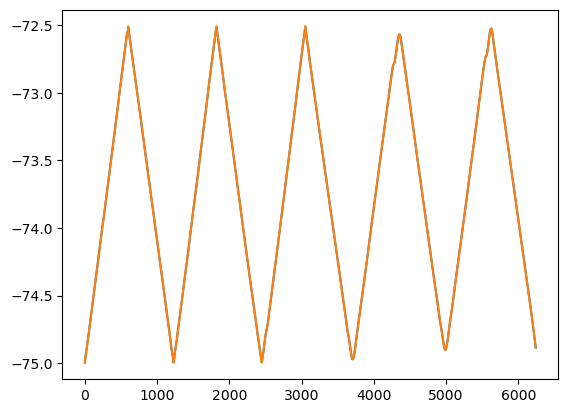

In [51]:
print(col[flt]['obs_id'])
print(halo[flt]['obs_id'])
plt.plot(col[flt]['lon'])
plt.plot(halo[flt]['lon'])

In [92]:
col[flt][f'dxch4_{enm}'].shape
halo[flt][f'dxch4'].shape

(678,)

## XCH4 Enhancement Plots

- HALO-WRF_bck dXCH4
- Pitt dXCH4
- EDGAR dXCH4
- EPA dXCH4

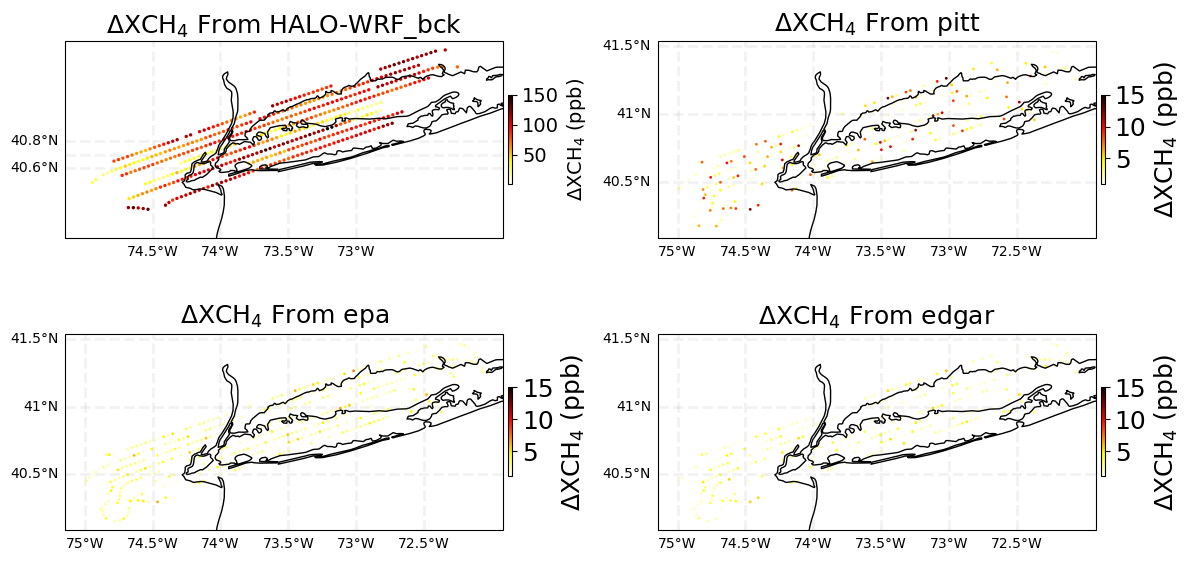

In [95]:
flt = '20230726_F1'
fig,axs = plt.subplots(2,2,figsize=(12,6),subplot_kw={'projection': ccrs.PlateCarree()})
bnds = [1,15]

ax = axs[0,0]
g = ax.scatter(halo[flt]['lon'],halo[flt]['lat'],c=halo[flt]['dxch4']*1e3,cmap=plt.cm.hot_r,transform=ccrs.PlateCarree(),vmin=bnds[0],vmax=150,s=2);
ax.coastlines()
cb = plt.colorbar(g,ax=ax,fraction=0.01,pad=0.01)#,orientation='horizontal')
ax.set_title(f'$\Delta$XCH$_4$ From HALO-WRF_bck',fontsize=18)
#ax.set_xticks(np.linspace(-75,-72,4))
cb.ax.tick_params(labelsize=14)
cb.ax.set_ylabel('$\Delta$XCH$_4$ (ppb)',fontsize=14)
#ax.contour(lon_2km,lat_2km,xco2_b_2km,np.array([-1.0]),cmap=plt.cm.terrain,linewidths=3)
gl = ax.gridlines(xlocs=[-74.5,-74.0,-73.5,-73.0],ylocs=[40.6,40.7,40.8],crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.1, linestyle='--')
gl.top_labels = False
gl.right_labels = False

for ik,ky in enumerate(emis.keys()):
    cmp = plt.cm.hot_r
    ax = axs[(ik+1)//2,(ik+1)%2]
    g = ax.scatter(halo[flt]['lon'],halo[flt]['lat'],c=col[flt][f'dxch4_{ky}'].sum(1)*1e3,cmap=cmp,transform=ccrs.PlateCarree(),vmin=bnds[0],vmax=bnds[1],s=1);
    ax.coastlines()
    cb = plt.colorbar(g,ax=ax,fraction=0.01,pad=0.01)#,orientation='horizontal')
    ax.set_title(f'$\Delta$XCH$_4$ From {ky}',fontsize=18)
    #ax.set_xticks(np.linspace(-75,72,4))
    cb.ax.tick_params(labelsize=18)
    cb.ax.set_ylabel('$\Delta$XCH$_4$ (ppb)',fontsize=18)
    #ax.contour(lon_2km,lat_2km,xco2_b_2km,np.array([-1.0]),cmap=plt.cm.terrain,linewidths=3)
    gl = ax.gridlines(xlocs=[-75.,-74.5,-74.0,-73.5,-73.0,-72.5],ylocs=[40.0,40.5,41.0,41.5],crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.1, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

fig.tight_layout()
fig.savefig('halo_vs_model_enhancements.png',bbox_inches='tight')

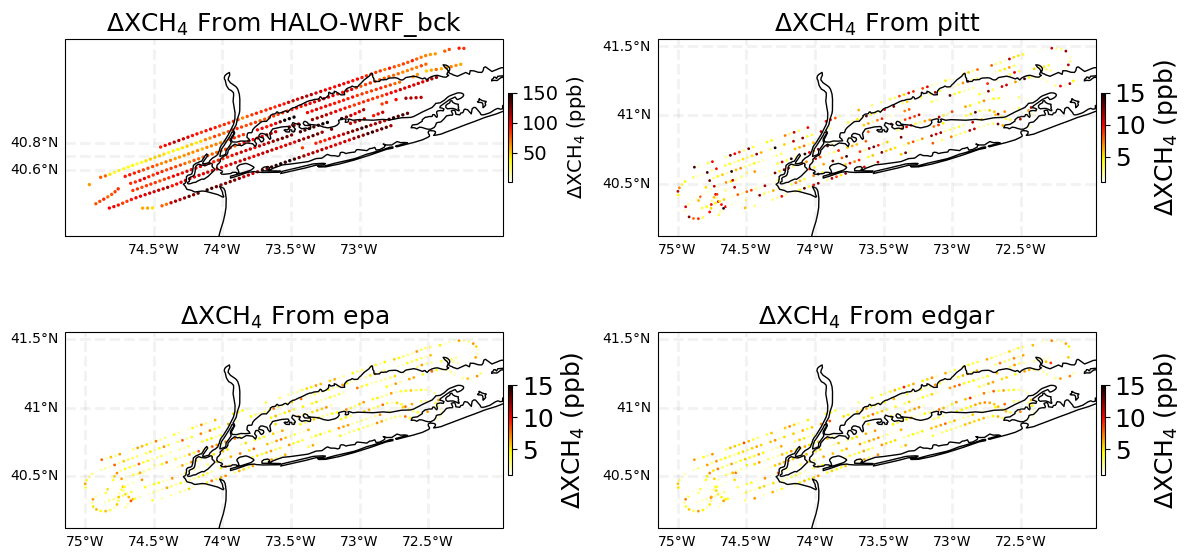

In [96]:
flt = '20230726_F2'
fig,axs = plt.subplots(2,2,figsize=(12,6),subplot_kw={'projection': ccrs.PlateCarree()})
bnds = [1,15]

ax = axs[0,0]
g = ax.scatter(halo[flt]['lon'],halo[flt]['lat'],c=halo[flt]['dxch4']*1e3,cmap=plt.cm.hot_r,transform=ccrs.PlateCarree(),vmin=bnds[0],vmax=150,s=2);
ax.coastlines()
cb = plt.colorbar(g,ax=ax,fraction=0.01,pad=0.01)#,orientation='horizontal')
ax.set_title(f'$\Delta$XCH$_4$ From HALO-WRF_bck',fontsize=18)
#ax.set_xticks(np.linspace(-75,-72,4))
cb.ax.tick_params(labelsize=14)
cb.ax.set_ylabel('$\Delta$XCH$_4$ (ppb)',fontsize=14)
#ax.contour(lon_2km,lat_2km,xco2_b_2km,np.array([-1.0]),cmap=plt.cm.terrain,linewidths=3)
gl = ax.gridlines(xlocs=[-74.5,-74.0,-73.5,-73.0],ylocs=[40.6,40.7,40.8],crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.1, linestyle='--')
gl.top_labels = False
gl.right_labels = False

for ik,ky in enumerate(emis.keys()):
    cmp = plt.cm.hot_r
    ax = axs[(ik+1)//2,(ik+1)%2]
    g = ax.scatter(halo[flt]['lon'],halo[flt]['lat'],c=col[flt][f'dxch4_{ky}'].sum(1)*1e3,cmap=cmp,transform=ccrs.PlateCarree(),vmin=bnds[0],vmax=bnds[1],s=1);
    ax.coastlines()
    cb = plt.colorbar(g,ax=ax,fraction=0.01,pad=0.01)#,orientation='horizontal')
    ax.set_title(f'$\Delta$XCH$_4$ From {ky}',fontsize=18)
    #ax.set_xticks(np.linspace(-75,72,4))
    cb.ax.tick_params(labelsize=18)
    cb.ax.set_ylabel('$\Delta$XCH$_4$ (ppb)',fontsize=18)
    #ax.contour(lon_2km,lat_2km,xco2_b_2km,np.array([-1.0]),cmap=plt.cm.terrain,linewidths=3)
    gl = ax.gridlines(xlocs=[-75.,-74.5,-74.0,-73.5,-73.0,-72.5],ylocs=[40.0,40.5,41.0,41.5],crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.1, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

fig.tight_layout()
fig.savefig('halo_vs_model_enhancements.png',bbox_inches='tight')

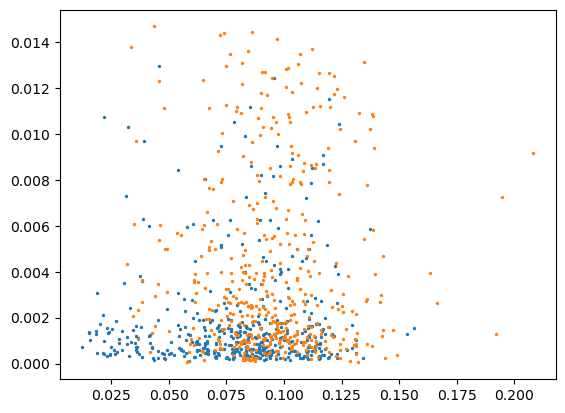

In [97]:
for flt in flts:
    inds = np.where(1-np.isnan(halo[flt]['dxch4']))
    plt.scatter(halo[flt]['dxch4'][inds],col[flt]['dxch4_pitt'].sum(1)[inds],s=2)

# Optimizing Flux Scalar Multiple - IN WORK
Using the formulas in Ye et al (2020) (https://doi.org/10.1029/2019JD030528):

We solve for a single scalar $\lambda$ that scales an inventory up or down. The linearity of the transport means that we can simulate the observations from the inventory once and optimize the mismatch:

$J(\lambda) = (y_o-\lambda y_m)^\mathsf{T} S_o^{-1} (y_o-\lambda y_m) + (\lambda-\lambda_a)^2\sigma_a^{-2}$

with optimizer $\hat{\lambda}$:

$\hat{\lambda} = (y_m^{\mathsf{T}}S_o^{-1}y_m + \sigma_a^{-2})^{-1}(y_m^{\mathsf{T}}S_o^{-1}y_o + \sigma_a^{-2}\lambda_a)$

and uncertainty $\hat{\sigma}^2$:

$\hat{\sigma}^2 = (y_m^{\mathsf{T}}S_o^{-1}y_m + \sigma_a^{-2})^{-1}$


### Read in Emissions

## Methane Optimization

In [11]:
f = File('ch4_emissions_footprint_grid.h5','r')

lat = f['lat'][:]
lon = f['lon'][:]

lat_lb = 40.5
lat_ub = 41.0
lon_lb = -74.5
lon_ub = -73.5
lat_lb_ind = np.where(lat > lat_lb)[0][0]
lat_ub_ind = np.where(lat < lat_ub)[0][-1]
lon_lb_ind = np.where(lon > lon_lb)[0][0]
lon_ub_ind = np.where(lon < lon_ub)[0][-1]

epa_ch4 = f['epa'][:].mean((1,2))#[:,lat_lb_ind:lat_ub_ind,lon_lb_ind:lon_ub_ind].mean((1,2))
edgar_ch4 = f['edgar'][:].mean((1,2))#[:,lat_lb_ind:lat_ub_ind,lon_lb_ind:lon_ub_ind].mean((1,2))
epav2_ch4 = f['epav2'][:].mean((1,2))#[:,lat_lb_ind:lat_ub_ind,lon_lb_ind:lon_ub_ind].mean((1,2))
pitt_ch4 = f['pitt'][:].mean((1,2))#[:,lat_lb_ind:lat_ub_ind,lon_lb_ind:lon_ub_ind].mean((1,2))

### No Noise

Text(0.5, 0, 'Hour')

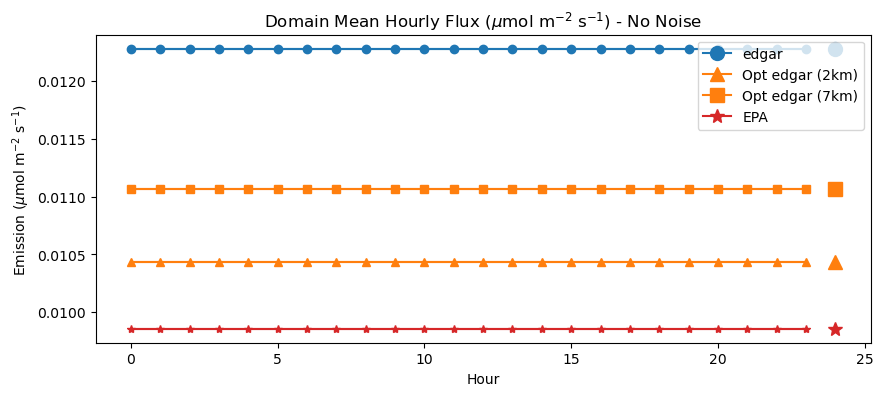

In [12]:
y_m = xch4_e_2km[:].flatten() #EDGAR
y_o = xch4_d_2km[:].flatten() #EPA

lam_apri = 1.
sig_obs = 5.
sig_apri = 0.3

sig_hat_2km = (np.dot(y_m,y_m)*sig_obs**(-2) + sig_apri**(-2))**(-1)
lam_hat_2km = sig_hat_2km*(np.dot(y_m,y_o)*sig_obs**(-2) + lam_apri*sig_apri**(-2))

y_m = xch4_e_7km[:].flatten() #EDGAR
y_o = xch4_d_7km[:].flatten() #EPA


sig_hat_7km = (np.dot(y_m,y_m)*sig_obs**(-2) + sig_apri**(-2))**(-1)
lam_hat_7km = sig_hat_7km*(np.dot(y_m,y_o)*sig_obs**(-2) + lam_apri*sig_apri**(-2))

fig,ax = plt.subplots(1,1,figsize=(10,4))

#ax = axs[0]
ax.plot(lam_apri*edgar_ch4)
ax.plot(lam_apri*edgar_ch4,'tab:blue',marker='o')
g1 = ax.plot([24],[lam_apri*edgar_ch4.mean()],'tab:blue',marker='o',ms=10)

ax.plot(lam_hat_2km*edgar_ch4,'tab:orange')
ax.plot(lam_hat_2km*edgar_ch4,'tab:orange',marker='^')
g2 = ax.plot([24],[lam_hat_2km*edgar_ch4.mean()],'tab:orange',marker='^',ms=10)

ax.plot(lam_hat_7km*edgar_ch4,'tab:orange')
ax.plot(lam_hat_7km*edgar_ch4,'tab:orange',marker='s')
g3 = ax.plot([24],[lam_hat_7km*edgar_ch4.mean()],'tab:orange',marker='s',ms=10)

ax.plot(epa_ch4,'tab:red')
ax.plot(epa_ch4,'tab:red',marker='*')
g4 = ax.plot([24],[epa_ch4.mean()],'tab:red',marker='*',ms=10)

ax.legend([g1[0],g2[0],g3[0],g4[0]],['edgar','Opt edgar (2km)','Opt edgar (7km)','EPA'])
ax.set_title(r'Domain Mean Hourly Flux ($\mu$mol m$^{-2}$ s$^{-1}$) - No Noise')
ax.set_ylabel(r'Emission ($\mu$mol m$^{-2}$ s$^{-1}$)')
ax.set_xlabel(r'Hour')

(0.00816576254229103, 0.016331525084582056)

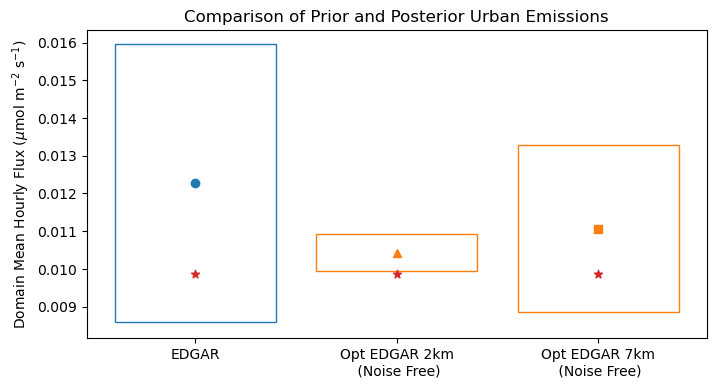

In [15]:

plt.figure(figsize=(8,4))
plt.bar(1,bottom=(lam_apri-sig_apri)*edgar_ch4.mean(),height=2*sig_apri*edgar_ch4.mean(),edgecolor='tab:blue',facecolor='w')
plt.bar(2,bottom=(lam_hat_2km-np.sqrt(sig_hat_2km))*edgar_ch4.mean(),height=2*np.sqrt(sig_hat_2km)*edgar_ch4.mean(),facecolor='w',edgecolor='tab:orange')
plt.bar(3,bottom=(lam_hat_7km-np.sqrt(sig_hat_7km))*edgar_ch4.mean(),height=2*np.sqrt(sig_hat_7km)*edgar_ch4.mean(),facecolor='w',edgecolor='tab:orange')

plt.plot(np.array([1]),edgar_ch4.mean(),'o',color='tab:blue')
plt.plot(np.array([2]),lam_hat_2km*edgar_ch4.mean(),'^',color='tab:orange')
plt.plot(np.array([3]),lam_hat_7km*edgar_ch4.mean(),'s',color='tab:orange')


plt.scatter(np.arange(1,4,1),epa_ch4.mean()*np.ones(3),c='tab:red',marker='*')
plt.xticks([1,2,3],['EDGAR','Opt EDGAR 2km\n (Noise Free)','Opt EDGAR 7km\n (Noise Free)'])
plt.ylabel(r'Domain Mean Hourly Flux ($\mu$mol m$^{-2}$ s$^{-1}$)')
plt.title('Comparison of Prior and Posterior Urban Emissions')
yl = plt.gca().get_ylim()
plt.ylim([yl[0]*0.95,yl[1]])

0.27278949603984515

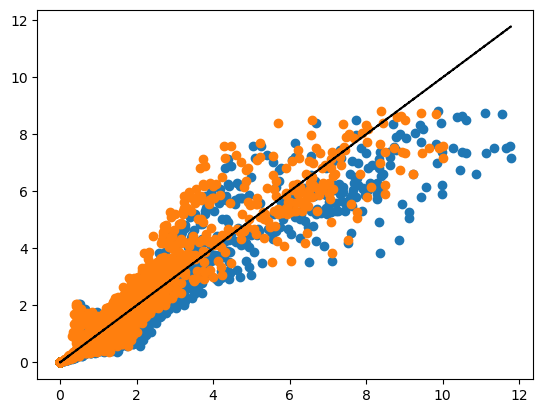

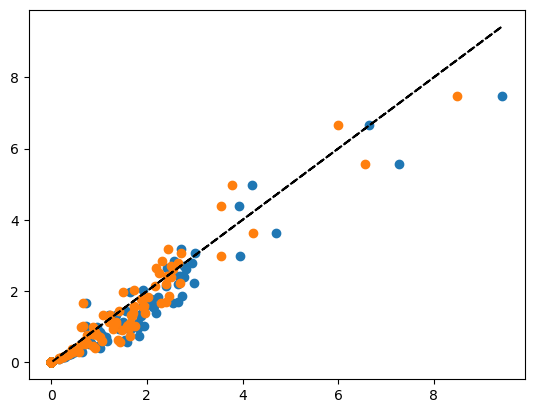

In [21]:
plt.scatter(xch4_e_2km[:].flatten(),xch4_d_2km[:].flatten())
plt.scatter(lam_hat_2km*xch4_e_2km[:].flatten(),xch4_d_2km[:].flatten())
plt.plot(xch4_e_2km[:].flatten(),xch4_e_2km[:].flatten(),'--k')
plt.figure()
plt.scatter(xch4_e_7km[:].flatten(),xch4_d_7km[:].flatten())
plt.scatter(lam_hat_7km*xch4_e_7km[:].flatten(),xch4_d_7km[:].flatten())
plt.plot(xch4_e_7km[:].flatten(),xch4_e_7km[:].flatten(),'--k')
1-(np.sqrt((lam_hat_2km*xch4_e_2km-xch4_d_2km).flatten()**2).mean())/(np.sqrt((xch4_e_2km-xch4_d_2km).flatten()**2).mean())
1-(np.sqrt((lam_hat_2km*xch4_e_7km-xch4_d_7km).flatten()**2).mean())/(np.sqrt((xch4_e_7km-xch4_d_7km).flatten()**2).mean())

### Monte Carlo for Validation

(0.008362415302889364, 0.01637400275246264)

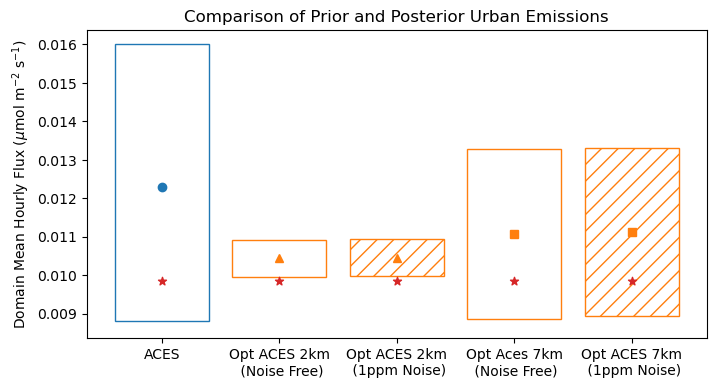

In [44]:
lam_hat_2km_n = np.zeros(1000)
lam_hat_7km_n = np.zeros(1000)
sig_hat_2km_n = np.zeros(1000)
sig_hat_7km_n = np.zeros(1000)
lam_apri = np.zeros(1000)
for i in range(1000):
    
    sig_obs = 5.
    sig_apri = 0.3
    lam_apri[i] = 1.+ sig_apri*np.random.randn()
    
    noise_2km = sig_obs*(np.random.randn(*xch4_e_2km.shape)*lsm_2km).flatten()
    noise_7km = sig_obs*(np.random.randn(*xch4_e_7km.shape)*lsm_7km).flatten()

    y_m = xch4_e_2km[:].flatten() #EDGAR
    y_o = xch4_d_2km[:].flatten() + noise_2km
 
    sig_hat_2km_n[i] = (np.dot(y_m,y_m)*sig_obs**(-2) + sig_apri**(-2))**(-1)
    lam_hat_2km_n[i] = sig_hat_2km_n[i]*(np.dot(y_m,y_o)*sig_obs**(-2) + lam_apri[i]*sig_apri**(-2))

    y_m = xch4_e_7km[:].flatten() #EDGAR
    y_o = xch4_d_7km[:].flatten() + noise_7km

    sig_hat_7km_n[i] = (np.dot(y_m,y_m)*sig_obs**(-2) + sig_apri**(-2))**(-1)
    lam_hat_7km_n[i] = sig_hat_7km_n[i]*(np.dot(y_m,y_o)*sig_obs**(-2) + lam_apri[i]*sig_apri**(-2))

plt.figure(figsize=(8,4))
plt.bar(1,bottom=(lam_apri.mean()-lam_apri.std())*edgar_ch4.mean(),height=2*lam_apri.std()*edgar_ch4.mean(),edgecolor='tab:blue',facecolor='w')
plt.bar(2,bottom=(lam_hat_2km-np.sqrt(sig_hat_2km))*edgar_ch4.mean(),height=2*np.sqrt(sig_hat_2km)*edgar_ch4.mean(),facecolor='w',edgecolor='tab:orange')
plt.bar(3,bottom=(lam_hat_2km_n.mean()-lam_hat_2km_n.std())*edgar_ch4.mean(),height=2*lam_hat_2km_n.std()*edgar_ch4.mean(),hatch='//',facecolor='w',edgecolor='tab:orange')
plt.bar(4,bottom=(lam_hat_7km-np.sqrt(sig_hat_7km))*edgar_ch4.mean(),height=2*np.sqrt(sig_hat_7km)*edgar_ch4.mean(),facecolor='w',edgecolor='tab:orange')
plt.bar(5,bottom=(lam_hat_7km_n.mean()-lam_hat_7km_n.std())*edgar_ch4.mean(),height=2*lam_hat_7km_n.std()*edgar_ch4.mean(),hatch='//',facecolor='w',edgecolor='tab:orange')

plt.plot(np.array([1]),edgar_ch4.mean(),'o',color='tab:blue')
plt.plot(np.array([2]),lam_hat_2km*edgar_ch4.mean(),'^',color='tab:orange')
plt.plot(np.array([3]),lam_hat_2km_n.mean()*edgar_ch4.mean(),'^',color='tab:orange')
plt.plot(np.array([4]),lam_hat_7km*edgar_ch4.mean(),'s',color='tab:orange')
plt.plot(np.array([5]),lam_hat_7km_n.mean()*edgar_ch4.mean(),'s',color='tab:orange')


plt.scatter(np.arange(1,6,1),epa_ch4.mean()*np.ones(5),c='tab:red',marker='*')
plt.xticks([1,2,3,4,5],['ACES','Opt ACES 2km\n (Noise Free)','Opt ACES 2km\n (1ppm Noise)','Opt Aces 7km\n (Noise Free)','Opt ACES 7km\n (1ppm Noise)'])
plt.ylabel(r'Domain Mean Hourly Flux ($\mu$mol m$^{-2}$ s$^{-1}$)')
plt.title('Comparison of Prior and Posterior Urban Emissions')
yl = plt.gca().get_ylim()
plt.ylim([yl[0]*0.95,yl[1]])

In [56]:
(edgar_ch4.mean()/epa_ch4.mean()-edgar_ch4.mean()/epa_ch4.mean()*lam_hat_2km)/(edgar_ch4.mean()/epa_ch4.mean())

0.15025143629307847

In [53]:
6000*13*1000*8/1024

609375.0